In [ ]:
# @title
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan, acorr_breusch_godfrey
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.sandwich_covariance import cov_hac
import yfinance as yf

In [ ]:
# @title
# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


In [ ]:
# @title
# Define tickers
stock_ticker = "NVDA"
market_ticker = "^GSPC"  # S&P 500
gold_ticker = "GC=F"      # Gold Futures in USD

# Download 5 years of historical data
print("Downloading data...")
data = yf.download([stock_ticker, market_ticker, gold_ticker],
                   start="2019-01-09",
                   end="2024-01-09",
                   group_by='ticker')  # Group by ticker

print("✓ Data downloaded!")
print("\nData structure:")
print(data.head())

# Extract adjusted close prices for each ticker
prices = pd.DataFrame()
prices['NVDA'] = data[stock_ticker]['Close']
prices['SNP500'] = data[market_ticker]['Close']
prices['Gold'] = data[gold_ticker]['Close']

# Remove any rows with missing values
prices = prices.dropna()


print(f"Date range: {prices.index[0]} to {prices.index[-1]}")
print(f"Total observations: {len(prices)}")
print("\nFirst few rows of prices:")
print(prices.head())
print("\nLast few rows of prices:")
print(prices.tail())
print("\nMissing values:")
print(prices.isnull().sum())

/tmp/ipython-input-457142551.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download([stock_ticker, market_ticker, gold_ticker],
[*********************100%***********************]  3 of 3 completed

✓ Data downloaded!

Data structure:
Ticker             GC=F                                                \
Price              Open         High          Low        Close Volume   
Date                                                                    
2019-01-09  1279.400024  1289.300049  1279.199951  1289.300049    102   
2019-01-10  1284.699951  1284.699951  1284.699951  1284.699951      0   
2019-01-11  1291.199951  1291.199951  1286.300049  1287.099976     11   
2019-01-14  1292.400024  1293.900024  1289.099976  1289.099976      7   
2019-01-15  1290.099976  1292.699951  1286.199951  1286.199951      3   

Ticker            ^GSPC                                                     \
Price              Open         High          Low        Close      Volume   
Date                                                                         
2019-01-09  2580.000000  2595.320068  2568.889893  2584.959961  4088740000   
2019-01-10  2573.510010  2597.820068  2562.020020  2596.639893  372

In [ ]:
# @title
# Calculate daily percentage returns
returns = prices.pct_change() * 100  # Convert to percentage
returns = returns.dropna()  # Remove first row (NaN)

# Rename columns for clarity
returns.columns = ['rGold', 'rNVDA', 'rSNP500']


print(f"Total return observations: {len(returns)}")
print("\nDescriptive statistics of returns:")
print(returns.describe())
print("\nFirst few rows of returns:")
print(returns.head(10))

Total return observations: 1257

Descriptive statistics of returns:
             rGold        rNVDA      rSNP500
count  1257.000000  1257.000000  1257.000000
mean      0.267000     0.057643     0.040877
std       3.253928     1.338484     0.989144
min     -18.452095   -11.984055    -4.978726
25%      -1.515212    -0.524238    -0.420516
50%       0.305382     0.088779     0.049862
75%       1.981003     0.714779     0.553423
max      24.369632     9.382774     5.947668

First few rows of returns:
               rGold     rNVDA   rSNP500
Date                                    
2019-01-10  1.858619  0.451842 -0.356790
2019-01-11  2.478836 -0.014630  0.186816
2019-01-14  1.081742 -0.525753  0.155388
2019-01-15 -0.378877  1.072169 -0.224965
2019-01-16 -0.687258  0.222199  0.419843
2019-01-17  1.934944  0.759140 -0.046452
2019-01-18  3.433977  1.318305 -0.751352
2019-01-22 -5.199768 -1.415731  0.093651
2019-01-23  0.349531  0.220291  0.046782
2019-01-24  5.727109  0.137573 -0.311745


In [ ]:
# @title
# Check for any missing values
print("Missing values in returns:")
print(returns.isnull().sum())

# Check for any infinite values
print("\nInfinite values in returns:")
print(np.isinf(returns).sum())

# Basic statistics
print("\n" + "="*50)
print("SUMMARY STATISTICS")
print("="*50)
for col in returns.columns:
    print(f"\n{col}:")
    print(f"  Mean: {returns[col].mean():.4f}%")
    print(f"  Std Dev: {returns[col].std():.4f}%")
    print(f"  Min: {returns[col].min():.4f}%")
    print(f"  Max: {returns[col].max():.4f}%")
    print(f"  Observations: {len(returns[col])}")

Missing values in returns:
rGold      0
rNVDA      0
rSNP500    0
dtype: int64

Infinite values in returns:
rGold      0
rNVDA      0
rSNP500    0
dtype: int64

SUMMARY STATISTICS

rGold:
  Mean: 0.2670%
  Std Dev: 3.2539%
  Min: -18.4521%
  Max: 24.3696%
  Observations: 1257

rNVDA:
  Mean: 0.0576%
  Std Dev: 1.3385%
  Min: -11.9841%
  Max: 9.3828%
  Observations: 1257

rSNP500:
  Mean: 0.0409%
  Std Dev: 0.9891%
  Min: -4.9787%
  Max: 5.9477%
  Observations: 1257


In [ ]:
# @title
# Question 1a: Regression with market and gold
# Model: ri = β0 + β1*rm + β2*rg + ui

# Prepare the data
y = returns['rNVDA']  # Dependent variable (stock returns)
X = returns[['rSNP500', 'rGold']]  # Independent variables (market and gold)
X = sm.add_constant(X)  # Add intercept

# Run OLS regression
model_1a = sm.OLS(y, X).fit()

# Display results
print("="*70)
print("QUESTION 1a: OLS REGRESSION WITH MARKET AND GOLD")
print("="*70)
print("Model: rNVDA = β0 + β1*rSNP500 + β2*rGold + u")
print("\n")
print(model_1a.summary())

# Store coefficients for later use
beta0_1a = model_1a.params['const']
beta1_1a = model_1a.params['rSNP500']
beta2_1a = model_1a.params['rGold']

print("\n" + "="*70)
print("KEY COEFFICIENTS:")
print("="*70)
print(f"β0 (Intercept): {beta0_1a:.6f}")
print(f"β1 (Market):    {beta1_1a:.6f}")
print(f"β2 (Gold):      {beta2_1a:.6f}")
print(f"R-squared:      {model_1a.rsquared:.6f}")
print(f"Adj R-squared:  {model_1a.rsquared_adj:.6f}")

QUESTION 1a: OLS REGRESSION WITH MARKET AND GOLD
Model: rNVDA = β0 + β1*rSNP500 + β2*rGold + u


                            OLS Regression Results                            
Dep. Variable:                  rNVDA   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     645.6
Date:                Thu, 20 Nov 2025   Prob (F-statistic):          1.76e-193
Time:                        21:39:08   Log-Likelihood:                -1704.7
No. Observations:                1257   AIC:                             3415.
Df Residuals:                    1254   BIC:                             3431.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

## 1a. Interpretation of Model 1a

The estimated model is:
rNVDA = β0 + β1 rSNP500 + β2 rGold + u

The intercept estimate is −0.022 with a p value of 0.406. It is not statistically different from zero, which indicates that NVDA’s average return is essentially zero when both explanatory variables are zero.
The coefficient on the market return is 0.048 with a p value of 0.074. This estimate is small and only marginally significant. It suggests that NVDA’s sensitivity to market movements is limited in this specification.
The coefficient on gold returns is 0.291 with a p value below 0.001. Gold returns are therefore a statistically significant explanatory variable.

A one percent increase in gold returns is associated with a 0.29 percent increase in NVDA returns, while a one percent increase in market returns corresponds to only a 0.05 percent increase. The signs and magnitudes indicate that gold contributes meaningfully to NVDA’s short-run variation, while market sensitivity remains limited in this specification.

The model explains approximately 50.7 percent of the variation in NVDA’s daily returns. Residual diagnostics indicate non normality, skewness, heavy tails, and the presence of outliers, which are common in financial return data.

This model captures a substantial part of return variation, although the presence of volatility spikes indicates that additional dynamics such as heteroscedasticity may still be relevant.



In [ ]:
# @title
# Question 1b: Regression without gold
# Model: ri = β0 + β1*rm + ui

print("\n" + "="*70)
print("QUESTION 1b: OLS REGRESSION WITHOUT GOLD")
print("="*70)
print("Model: rNVDA = β0 + β1*rSNP500 + u")
print("\n")

# Prepare the data
y = returns['rNVDA']  # Dependent variable
X_1b = returns[['rSNP500']]  # Only market returns
X_1b = sm.add_constant(X_1b)  # Add intercept

# Run OLS regression
model_1b = sm.OLS(y, X_1b).fit()

# Display results
print(model_1b.summary())

# Store coefficients
beta0_1b = model_1b.params['const']
beta1_1b = model_1b.params['rSNP500']

print("\n" + "="*70)
print("KEY COEFFICIENTS:")
print("="*70)
print(f"β0 (Intercept): {beta0_1b:.6f}")
print(f"β1 (Market):    {beta1_1b:.6f}")
print(f"R-squared:      {model_1b.rsquared:.6f}")
print(f"Adj R-squared:  {model_1b.rsquared_adj:.6f}")

# Comparison between models
print("\n" + "="*70)
print("MODEL COMPARISON (1a vs 1b)")
print("="*70)
print(f"{'Metric':<20} {'Model 1a (with Gold)':<25} {'Model 1b (without Gold)':<25}")
print("-"*70)
print(f"{'R-squared':<20} {model_1a.rsquared:<25.6f} {model_1b.rsquared:<25.6f}")
print(f"{'Adj R-squared':<20} {model_1a.rsquared_adj:<25.6f} {model_1b.rsquared_adj:<25.6f}")
print(f"{'AIC':<20} {model_1a.aic:<25.2f} {model_1b.aic:<25.2f}")
print(f"{'BIC':<20} {model_1a.bic:<25.2f} {model_1b.bic:<25.2f}")
print(f"{'Market Beta':<20} {beta1_1a:<25.6f} {beta1_1b:<25.6f}")
print(f"{'F-statistic':<20} {model_1a.fvalue:<25.2f} {model_1b.fvalue:<25.2f}")


QUESTION 1b: OLS REGRESSION WITHOUT GOLD
Model: rNVDA = β0 + β1*rSNP500 + u


                            OLS Regression Results                            
Dep. Variable:                  rNVDA   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     10.70
Date:                Thu, 20 Nov 2025   Prob (F-statistic):            0.00110
Time:                        21:39:08   Log-Likelihood:                -2144.2
No. Observations:                1257   AIC:                             4292.
Df Residuals:                    1255   BIC:                             4303.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

## 1b. Model Comparison

Model 1a is superior to Model 1b. Its R squared of 0.507 is substantially higher than the 0.008 obtained from Model 1b. Model 1a also has lower AIC and BIC values. The inclusion of gold captures additional variation in NVDA’s returns and improves the explanatory power of the model.
Based on this evidence, Model 1a provides a more accurate description of NVDA’s return behaviour.

Model 1b provides almost no explanatory power, while Model 1a explains over half the variation in NVDA returns.

In [ ]:
# @title
# Question 2: Test if β1 = 1 (market beta equals 1)
# H0: β1 = 1
# H1: β1 ≠ 1

print("="*70)
print("QUESTION 2: HYPOTHESIS TEST FOR β₁ = 1")
print("="*70)
print("H₀: β₁ = 1")
print("H₁: β₁ ≠ 1")
print("\n")

# Extract coefficient and standard error for β1 (rSNP500)
beta1_estimate = model_1a.params['rSNP500']
beta1_se = model_1a.bse['rSNP500']

# Calculate t-statistic for H0: β1 = 1
t_statistic = (beta1_estimate - 1) / beta1_se

# Degrees of freedom
df = model_1a.df_resid

# Calculate p-value (two-tailed test)
p_value = 2 * (1 - stats.t.cdf(abs(t_statistic), df))

# Critical value at 5% significance level (two-tailed)
alpha = 0.05
t_critical = stats.t.ppf(1 - alpha/2, df)

print(f"Estimated β₁:        {beta1_estimate:.6f}")
print(f"Standard Error:      {beta1_se:.6f}")
print(f"Hypothesized Value:  1.0000")
print(f"\nTest Statistic (t):  {t_statistic:.6f}")
print(f"Degrees of Freedom:  {df}")
print(f"P-value:             {p_value:.6f}")
print(f"Critical Value (5%): ±{t_critical:.6f}")

# Decision
print("\n" + "-"*70)
print("DECISION:")
print("-"*70)
if p_value < alpha:
    print(f"✓ REJECT H₀ (p-value = {p_value:.6f} < 0.05)")
    print(f"  There is sufficient evidence that β₁ ≠ 1")
else:
    print(f"✗ FAIL TO REJECT H₀ (p-value = {p_value:.6f} > 0.05)")
    print(f"  There is insufficient evidence that β₁ ≠ 1")

# Confidence interval
ci_lower = beta1_estimate - t_critical * beta1_se
ci_upper = beta1_estimate + t_critical * beta1_se
print(f"\n95% Confidence Interval for β₁: [{ci_lower:.6f}, {ci_upper:.6f}]")
print(f"Does the CI contain 1? {'YES' if ci_lower <= 1 <= ci_upper else 'NO'}")

QUESTION 2: HYPOTHESIS TEST FOR β₁ = 1
H₀: β₁ = 1
H₁: β₁ ≠ 1


Estimated β₁:        0.048191
Standard Error:      0.026907
Hypothesized Value:  1.0000

Test Statistic (t):  -35.373545
Degrees of Freedom:  1254.0
P-value:             0.000000
Critical Value (5%): ±1.961858

----------------------------------------------------------------------
DECISION:
----------------------------------------------------------------------
✓ REJECT H₀ (p-value = 0.000000 < 0.05)
  There is sufficient evidence that β₁ ≠ 1

95% Confidence Interval for β₁: [-0.004598, 0.100979]
Does the CI contain 1? NO


## 2. Test of H0: β1 = 1

The estimated β1 from Model 1a is 0.048. The t statistic for the test of β1 = 1 is −35.37 with a p value below 0.001. The 95 percent confidence interval for β1 is [−0.0046, 0.101]. Since the interval does not include 1, the null hypothesis is rejected.

Statistically, the market beta differs from 1. Economically, this suggests that NVDA does not move one for one with the market in this specification. The low estimate of β1 is likely influenced by the inclusion of gold, which absorbs a significant amount of variation.

This confirms that NVDA behaves much less like the market than a beta of one would imply.

In [ ]:
# @title
# Question 3: Test if β0 = β1 = β2 = 1
# This is an F-test for multiple restrictions

print("\n" + "="*70)
print("QUESTION 3: JOINT HYPOTHESIS TEST")
print("="*70)
print("H₀: β₀ = 1 AND β₁ = 1 AND β₂ = 1")
print("H₁: At least one coefficient ≠ 1")
print("\n")

# Define the restrictions: R*β = q
# Where β = [β0, β1, β2]' and we test if each equals 1

# Create restriction matrix
# We want to test: β0 = 1, β1 = 1, β2 = 1
restrictions = 'const = 1, rSNP500 = 1, rGold = 1'

# Perform F-test
f_test = model_1a.f_test(restrictions)

print("TEST RESULTS:")
print("-"*70)
print(f"F-statistic:     {f_test.fvalue:.6f}")
print(f"P-value:         {f_test.pvalue:.6f}")
print(f"Degrees of Freedom: ({f_test.df_num:.0f}, {f_test.df_denom:.0f})")

# Decision
alpha = 0.05
print("\n" + "-"*70)
print("DECISION:")
print("-"*70)
if f_test.pvalue < alpha:
    print(f"✓ REJECT H₀ (p-value = {f_test.pvalue:.6f} < 0.05)")
    print(f"  At least one coefficient is significantly different from 1")
else:
    print(f"✗ FAIL TO REJECT H₀ (p-value = {f_test.pvalue:.6f} > 0.05)")
    print(f"  Cannot conclude that any coefficient differs from 1")

# Show individual coefficients vs hypothesized value of 1
print("\n" + "-"*70)
print("INDIVIDUAL COEFFICIENT COMPARISON:")
print("-"*70)
print(f"{'Coefficient':<15} {'Estimate':<15} {'Hypothesized':<15} {'Difference':<15}")
print("-"*70)
print(f"{'β₀ (const)':<15} {beta0_1a:<15.6f} {1.0:<15.6f} {beta0_1a - 1:<15.6f}")
print(f"{'β₁ (SNP500)':<15} {beta1_1a:<15.6f} {1.0:<15.6f} {beta1_1a - 1:<15.6f}")
print(f"{'β₂ (Gold)':<15} {beta2_1a:<15.6f} {1.0:<15.6f} {beta2_1a - 1:<15.6f}")

# Also show t-statistics for each individual test
print("\n" + "-"*70)
print("INDIVIDUAL t-TESTS (each coefficient = 1):")
print("-"*70)
for param_name in ['const', 'rSNP500', 'rGold']:
    coef = model_1a.params[param_name]
    se = model_1a.bse[param_name]
    t_stat = (coef - 1) / se
    p_val = 2 * (1 - stats.t.cdf(abs(t_stat), model_1a.df_resid))
    print(f"{param_name:<15} t = {t_stat:8.4f},  p-value = {p_val:.6f}")


QUESTION 3: JOINT HYPOTHESIS TEST
H₀: β₀ = 1 AND β₁ = 1 AND β₂ = 1
H₁: At least one coefficient ≠ 1


TEST RESULTS:
----------------------------------------------------------------------
F-statistic:     3841.302138
P-value:         0.000000
Degrees of Freedom: (3, 1254)

----------------------------------------------------------------------
DECISION:
----------------------------------------------------------------------
✓ REJECT H₀ (p-value = 0.000000 < 0.05)
  At least one coefficient is significantly different from 1

----------------------------------------------------------------------
INDIVIDUAL COEFFICIENT COMPARISON:
----------------------------------------------------------------------
Coefficient     Estimate        Hypothesized    Difference     
----------------------------------------------------------------------
β₀ (const)      -0.022145       1.000000        -1.022145      
β₁ (SNP500)     0.048191        1.000000        -0.951809      
β₂ (Gold)       0.291452        

## 3. Joint Test of H0: β0 = β1 = β2 = 1

The joint F test yields an F statistic of 3841.30 with a p value below 0.001. The null hypothesis that all three parameters equal 1 is rejected.
Each estimated coefficient is far below 1. This result is consistent with the economic interpretation that NVDA does not move proportionally with either the market or gold returns, and that a constant return of 1 percent is not realistic.

A model in which all three coefficients equal one is economically implausible, since it would imply a constant 1 percent return every day and perfect one-to-one sensitivity to both market and gold movements.


QUESTION 4: RESIDUAL ANALYSIS


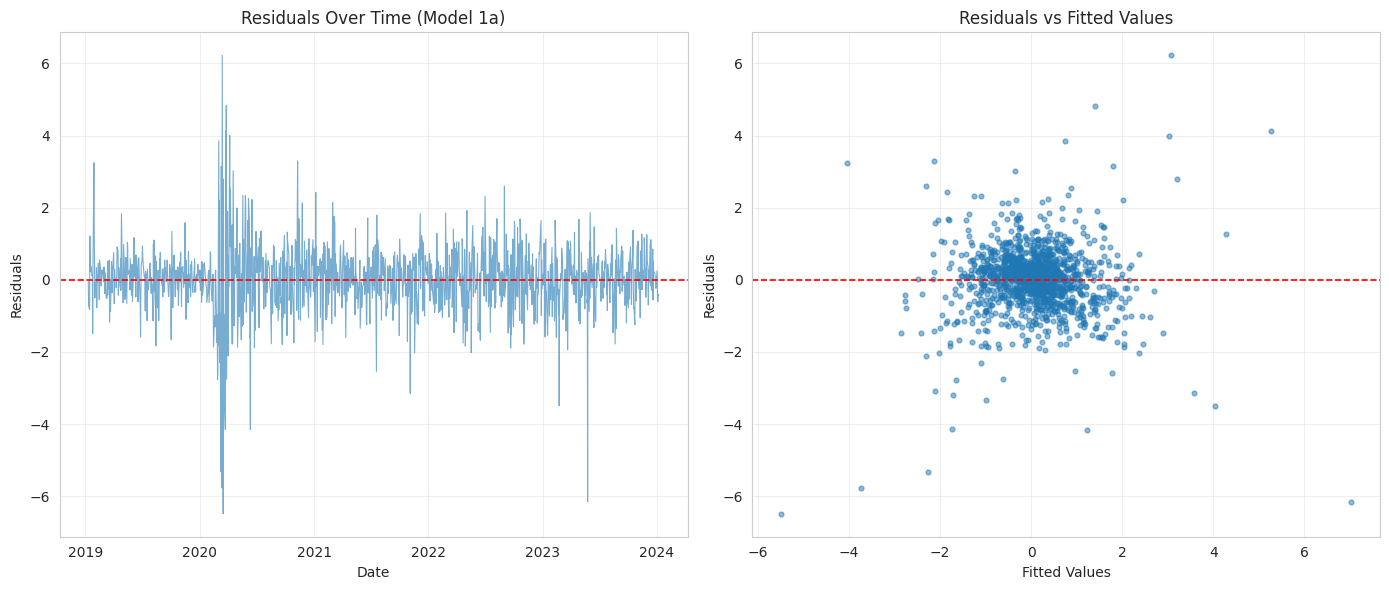

In [ ]:
# Question 4: Plot residuals of Model 1a

print("\n" + "="*70)
print("QUESTION 4: RESIDUAL ANALYSIS")
print("="*70)

residuals = model_1a.resid
fitted = model_1a.fittedvalues

plt.figure(figsize=(14, 6))

# --- Panel 1: Residuals over time ---
plt.subplot(1, 2, 1)
plt.plot(residuals.index, residuals, alpha=0.6, linewidth=0.8)
plt.axhline(0, color='r', linestyle='--', linewidth=1.2)
plt.title("Residuals Over Time (Model 1a)")
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.grid(True, alpha=0.3)

# --- Panel 2: Residuals vs Fitted ---
plt.subplot(1, 2, 2)
plt.scatter(fitted, residuals, alpha=0.5, s=12)
plt.axhline(0, color='r', linestyle='--', linewidth=1.2)
plt.title("Residuals vs Fitted Values")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 4. Residual Plot Interpretation

The residuals show clear volatility clustering, with periods of low variability followed by bursts of large movements. The sharp spike in early 2020 corresponds to the COVID-19 shock, which generated unusually large deviations that the model does not fully capture. The residuals vs fitted values plot shows a wider spread at certain fitted levels, which further indicates non constant variance. Together, these patterns are consistent with heteroscedasticity in the error terms.

The residuals vs fitted plot does not reveal clear nonlinear patterns, which supports the linear functional form of the model despite the changing variance.

The residuals remain centered near zero, indicating that the model does not systematically over or underpredict returns.

In [ ]:
# @title
# Question 5: Test for normality in residuals

print("\n" + "="*70)
print("QUESTION 5: NORMALITY TEST")
print("="*70)

residuals = model_1a.resid

# Jarque-Bera Test
jb_statistic, jb_pvalue, jb_skew, jb_kurtosis = jarque_bera(residuals)

print("\n1. JARQUE-BERA TEST")
print("-"*70)
print("H0: Residuals are normally distributed")
print("H1: Residuals are not normally distributed\n")

print(f"Test Statistic:  {jb_statistic:.6f}")
print(f"P-value:         {jb_pvalue:.6f}")
print(f"Skewness:        {jb_skew:.6f}")
print(f"Kurtosis:        {jb_kurtosis:.6f}")

alpha = 0.05
if jb_pvalue < alpha:
    print(f"\n✓ REJECT H0 (p-value = {jb_pvalue:.6f} < 0.05)")
    print("  Strong evidence against normality")
else:
    print(f"\n✗ FAIL TO REJECT H0 (p-value = {jb_pvalue:.6f} > 0.05)")
    print("  Insufficient evidence against normality")



QUESTION 5: NORMALITY TEST

1. JARQUE-BERA TEST
----------------------------------------------------------------------
H0: Residuals are normally distributed
H1: Residuals are not normally distributed

Test Statistic:  3755.271132
P-value:         0.000000
Skewness:        -0.480044
Kurtosis:        11.412961

✓ REJECT H0 (p-value = 0.000000 < 0.05)
  Strong evidence against normality


## 5. Normality Test

The Jarque Bera test yields a p value near zero, which indicates that the residuals are not normally distributed. The distribution shows negative skewness and substantial excess kurtosis, which is typical of financial return data. Although the normality assumption is violated, the large sample size allows OLS inference to remain approximately valid.

Given the large sample size, the violation of normality does not materially affect the validity of the regression’s inference Non-normality of residuals is common in high-frequency financial returns.

In [ ]:
# @title
# Question 6: Test for heteroscedasticity

print("\n" + "="*70)
print("QUESTION 6: HETEROSCEDASTICITY TESTS")
print("="*70)

residuals = model_1a.resid
X = returns[['rSNP500', 'rGold']]
X = sm.add_constant(X)

# 1. Breusch-Pagan Test
print("\n1. BREUSCH-PAGAN TEST")
print("-"*70)
print("H₀: Homoscedasticity (constant variance)")
print("H₁: Heteroscedasticity (non-constant variance)")
print()

bp_test_stat, bp_pvalue, bp_f_stat, bp_f_pvalue = het_breuschpagan(residuals, X)

print(f"LM Statistic:    {bp_test_stat:.6f}")
print(f"LM P-value:      {bp_pvalue:.6f}")
print(f"F-statistic:     {bp_f_stat:.6f}")
print(f"F P-value:       {bp_f_pvalue:.6f}")

alpha = 0.05
if bp_pvalue < alpha:
    print(f"\n✓ REJECT H₀ (p-value = {bp_pvalue:.6f} < 0.05)")
    print("  Evidence of heteroscedasticity")
else:
    print(f"\n✗ FAIL TO REJECT H₀ (p-value = {bp_pvalue:.6f} > 0.05)")
    print("  No evidence of heteroscedasticity")





QUESTION 6: HETEROSCEDASTICITY TESTS

1. BREUSCH-PAGAN TEST
----------------------------------------------------------------------
H₀: Homoscedasticity (constant variance)
H₁: Heteroscedasticity (non-constant variance)

LM Statistic:    8.852945
LM P-value:      0.011957
F-statistic:     4.447230
F P-value:       0.011896

✓ REJECT H₀ (p-value = 0.011957 < 0.05)
  Evidence of heteroscedasticity


## 6. Heteroscedasticity Test

The Breusch Pagan test (p = 0.012) provides evidence of heteroscedasticity, indicating that the variance of the residuals is not constant.

This result is consistent with the residual plot, which shows periods of higher and lower volatility. Because heteroscedasticity is present, the usual OLS standard errors may be unreliable, and robust methods are required.

This supports the use of heteroscedasticity-robust standard errors in later steps.

In [ ]:
# @title
# Question 7: Test for autocorrelation

print("\n" + "="*70)
print("QUESTION 7: AUTOCORRELATION TESTS")
print("="*70)

residuals = model_1a.resid

# 1. Durbin-Watson Test (already in model summary)
print("\n1. DURBIN-WATSON TEST")
print("-"*70)
print("Tests for first-order autocorrelation (AR(1))")
print("H₀: No autocorrelation (ρ = 0)")
print("H₁: Autocorrelation present (ρ ≠ 0)")
print()

from statsmodels.stats.stattools import durbin_watson
dw_statistic = durbin_watson(residuals)

print(f"Durbin-Watson Statistic: {dw_statistic:.6f}")
print()
print("Interpretation:")
print("  DW ≈ 2.0  → No autocorrelation")
print("  DW < 2.0  → Positive autocorrelation")
print("  DW > 2.0  → Negative autocorrelation")
print("  DW ≈ 0    → Strong positive autocorrelation")
print("  DW ≈ 4    → Strong negative autocorrelation")

if 1.5 < dw_statistic < 2.5:
    print(f"\n✓ No strong evidence of autocorrelation (DW = {dw_statistic:.3f} ≈ 2)")
else:
    print(f"\n✗ Evidence of autocorrelation (DW = {dw_statistic:.3f} deviates from 2)")

# 2. Breusch-Godfrey Test (Lagrange Multiplier test)
print("\n" + "="*70)
print("2. BREUSCH-GODFREY TEST (LM Test)")
print("-"*70)
print("Tests for autocorrelation up to specified lag")
print("H₀: No autocorrelation up to lag p")
print("H₁: Autocorrelation present")
print()

# Test for autocorrelation up to lag 5
max_lag = 5
bg_test = acorr_breusch_godfrey(model_1a, nlags=max_lag)

print(f"Testing up to lag {max_lag}:")
print(f"LM Statistic:    {bg_test[0]:.6f}")
print(f"P-value:         {bg_test[1]:.6f}")
print(f"F-statistic:     {bg_test[2]:.6f}")
print(f"F P-value:       {bg_test[3]:.6f}")

alpha = 0.05
if bg_test[1] < alpha:
    print(f"\n✓ REJECT H₀ (p-value = {bg_test[1]:.6f} < 0.05)")
    print("  Evidence of autocorrelation")
else:
    print(f"\n✗ FAIL TO REJECT H₀ (p-value = {bg_test[1]:.6f} > 0.05)")
    print("  No evidence of autocorrelation")




QUESTION 7: AUTOCORRELATION TESTS

1. DURBIN-WATSON TEST
----------------------------------------------------------------------
Tests for first-order autocorrelation (AR(1))
H₀: No autocorrelation (ρ = 0)
H₁: Autocorrelation present (ρ ≠ 0)

Durbin-Watson Statistic: 2.262998

Interpretation:
  DW ≈ 2.0  → No autocorrelation
  DW < 2.0  → Positive autocorrelation
  DW > 2.0  → Negative autocorrelation
  DW ≈ 0    → Strong positive autocorrelation
  DW ≈ 4    → Strong negative autocorrelation

✓ No strong evidence of autocorrelation (DW = 2.263 ≈ 2)

2. BREUSCH-GODFREY TEST (LM Test)
----------------------------------------------------------------------
Tests for autocorrelation up to specified lag
H₀: No autocorrelation up to lag p
H₁: Autocorrelation present

Testing up to lag 5:
LM Statistic:    39.206704
P-value:         0.000000
F-statistic:     8.042280
F P-value:       0.000000

✓ REJECT H₀ (p-value = 0.000000 < 0.05)
  Evidence of autocorrelation


## 7. Autocorrelation Test

The Durbin Watson statistic is 2.263, which suggests minimal first order autocorrelation. However, the Breusch Godfrey test identifies significant autocorrelation at higher lags.

This indicates that shocks in NVDA’s returns tend to persist briefly but not strongly. These dynamics suggest short-term dependence in return shocks, which Newey–West estimation can address.

In [ ]:
# @title
# Question 8: Newey-West HAC Standard Errors

print("\n" + "="*70)
print("QUESTION 8: NEWEY-WEST HAC STANDARD ERRORS")
print("="*70)

residuals = model_1a.resid
n_obs = len(returns)
maxlags = int(np.floor(4 * (n_obs / 100) ** (2/9)))

print(f"Sample size: {n_obs}")
print(f"Newey-West lags: {maxlags}")
print()

y = returns['rNVDA']
X = returns[['rSNP500', 'rGold']]
X = sm.add_constant(X)

# Estimate with Newey-West HAC standard errors
model_nw = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': maxlags})

print(model_nw.summary())



QUESTION 8: NEWEY-WEST HAC STANDARD ERRORS
Sample size: 1257
Newey-West lags: 7

                            OLS Regression Results                            
Dep. Variable:                  rNVDA   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     40.13
Date:                Thu, 20 Nov 2025   Prob (F-statistic):           1.28e-17
Time:                        21:52:57   Log-Likelihood:                -1704.7
No. Observations:                1257   AIC:                             3415.
Df Residuals:                    1254   BIC:                             3431.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------

## 8. Newey West Robust Standard Errors

Newey West estimation corrects for both heteroscedasticity and autocorrelation. The coefficient estimates remain unchanged. The standard errors increase for all parameters, most notably for gold, which increases from 0.008 to 0.033.
The market coefficient becomes clearly insignificant with a p value of 0.217. Gold remains highly significant with a p value below 0.001.

This correction confirms that only gold provides statistically robust explanatory power in the model. The coefficient values remain valid, but the revised standard errors provide more reliable inference for financial time series.

The main change after applying Newey West is an increase in standard errors, especially for the gold coefficient. This adjustment improves the reliability of inference, although the overall conclusions from Question 1 remain the same.

The corrected standard errors produce more conservative inference, typical in financial time series with clustered volatility.